# Objective

Prediction task: forecast sub-seasonal temperatures (over a two-week period) within the United States.

Data: weather and climate information for various US locations. Start dates for the two-week observation, as well as the forecasted temperature and precipitation from a number of weather forecast models (we will reveal the source of our dataset after the competition closes)

Each row correspons to a single location and a single start date for the two-week period.

Target: contest-tmp2m-14d__tmp2m, the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, computed as (measured max temperature + measured mini temperature) / 2

In [1]:
# loading library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from scipy.stats.stats import pearsonr

In [2]:
# read data
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# train.shape

In [5]:
# test.shape

In [6]:
# summary stats and putting in spreadsheet
# train.describe().T.to_csv("train_describe.csv", index=True)


In [7]:
train.dtypes

index                                         int64
lat                                         float64
lon                                         float64
startdate                                    object
contest-pevpr-sfc-gauss-14d__pevpr          float64
nmme0-tmp2m-34w__cancm30                    float64
nmme0-tmp2m-34w__cancm40                    float64
nmme0-tmp2m-34w__ccsm30                     float64
nmme0-tmp2m-34w__ccsm40                     float64
nmme0-tmp2m-34w__cfsv20                     float64
nmme0-tmp2m-34w__gfdlflora0                 float64
nmme0-tmp2m-34w__gfdlflorb0                 float64
nmme0-tmp2m-34w__gfdl0                      float64
nmme0-tmp2m-34w__nasa0                      float64
nmme0-tmp2m-34w__nmme0mean                  float64
contest-wind-h10-14d__wind-hgt-10           float64
nmme-tmp2m-56w__cancm3                      float64
nmme-tmp2m-56w__cancm4                      float64
nmme-tmp2m-56w__ccsm3                       float64
nmme-tmp2m-5

object items are:
* startdate
* climateregions__climateregion

int64 items are:
* index
* mjo1d__phase
* mei__meirank
* mei__nip

rest are float64 

In [8]:
train = pd.get_dummies(train, columns =['climateregions__climateregion'])

In [9]:
test.dtypes

index                                         int64
lat                                         float64
lon                                         float64
startdate                                    object
contest-pevpr-sfc-gauss-14d__pevpr          float64
nmme0-tmp2m-34w__cancm30                    float64
nmme0-tmp2m-34w__cancm40                    float64
nmme0-tmp2m-34w__ccsm30                     float64
nmme0-tmp2m-34w__ccsm40                     float64
nmme0-tmp2m-34w__cfsv20                     float64
nmme0-tmp2m-34w__gfdlflora0                 float64
nmme0-tmp2m-34w__gfdlflorb0                 float64
nmme0-tmp2m-34w__gfdl0                      float64
nmme0-tmp2m-34w__nasa0                      float64
nmme0-tmp2m-34w__nmme0mean                  float64
contest-wind-h10-14d__wind-hgt-10           float64
nmme-tmp2m-56w__cancm3                      float64
nmme-tmp2m-56w__cancm4                      float64
nmme-tmp2m-56w__ccsm3                       float64
nmme-tmp2m-5

In [10]:
test = pd.get_dummies(test, columns =['climateregions__climateregion'])

In [11]:
# cast policy startdate to datetime
train['startdate'] = pd.to_datetime(train['startdate'])
test['startdate'] = pd.to_datetime(train['startdate'])

In [12]:
# search = pd.DataFrame.duplicated(train)
# print(search[search == True])

In [13]:
# search = pd.DataFrame.duplicated(test)
# print(search[search == True])

In [14]:
#check for missing
null_columns=train.columns[train.isnull().sum() != 0]
print(train[null_columns].isnull().sum())

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64


There are features that share the same missing values. For example, ccsm30 has 15934 missing values and so do nmme0-prate-34w__ccsm30, nmme0-prate-56w__ccsm30, nmme0-prate-56w__ccsm30, and nmme0-tmp2m-34w__ccsm30. ccsm30 values are forecasts from weather models and those values could be used to forecast prate-34w__ccsm30, nmme0-prate-56w__ccsm30, nmme0-prate-56w__ccsm30, and nmme0-tmp2m-34w__ccsm30. The same thing might be the case for other features that used forecasted values to extrapolate their measurements.

*might need to check for spurious correlation


In [15]:
#check for missing
null_columns=test.columns[test.isnull().sum() != 0]
print(test[null_columns].isnull().sum())

Series([], dtype: float64)


Test dataset doesn't have any null columns so they don't have to treat for nulls

In [16]:
# train['climateregions__climateregion'].unique()

In [17]:
# test['climateregions__climateregion'].unique()

In [18]:
# plt.figure(figsize=(15,10))
# sns.lineplot(data=train, x='startdate', y='contest-tmp2m-14d__tmp2m',hue='climateregions__climateregion', ci=None)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [19]:
# # top 500 getting columns with a certain naming convention into a new df
# df_500 = train.head(500)
# df_500_nmme = df_500[[col for col in df_500.columns if 'nmme0-tmp2m-34w' in col]]

In [20]:
# # concat new df to add a startdate and targe variable, resetting index to be startdate, so x axis label is the startdate
# df_500_nmme = pd.concat([df_500_nmme, df_500[['contest-tmp2m-14d__tmp2m','startdate']]], axis=1)
# df_500_nmme = df_500_nmme.set_index('startdate')

# plt.figure(figsize=(20,15))
# #sns.lineplot(data=df_500_nmme, x='startdate', y='contest-tmp2m-14d__tmp2m', ci=None)

# #Plot all the columns in a single plot
# df_500_nmme.plot(kind='line')

# #Add a title and labels for the x and y axis
# plt.title(f'Temperature comparison (all nmme0-tmp2m-34w columns vs contest-tmp2m-14d__tmp2m)')
# plt.xlabel('Date')
# plt.ylabel('Temperature (°C)')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# #Show the plot
# plt.show()


Leonie made a feature location based on lat/lon coordinates, which makes sense if we want to better understand seasonal temps. Sub seasonal temps vary between locations across the continental US.
https://www.kaggle.com/code/iamleonie/wids-datathon-2023-forecasting-with-lgbm#Feature-Engineering

However there is an issue with the lat/lons. The test dataset has different locations. The issue was resolved by Flavia in her notebook where the issue stems from a rounding difference in the test data. She suggests truncating the train lat/lon. https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved#Solution

In [21]:
scale = 14

train.loc[:,'lat']=round(train.lat,scale)
train.loc[:,'lon']=round(train.lon,scale)

test.loc[:,'lat']=round(test.lat,scale)
test.loc[:,'lon']=round(test.lon,scale)

# Concatenate train and test data
all_df = pd.concat([train, test], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train = all_df.iloc[:len(train)]
test = all_df.iloc[len(train):]

514 unique locations


### Feature Engineering

From leonie:

Often times in Machine Learning, missing values are filled with the mean value. But as you can see below in pink, filling missing values with the mean value is not ideal. Our human intuition tells us that the time series values should not drop down to the mean value where the data points are missing. Instead the values should probably be filled with some value between 27 and 30.

For this purpose, we can use the .ffill() method, which just uses the last observed value to fill the missing value.

This is a popular approach to fill missing values in time series forecasting. It is also similar to the naive forecasting method. In naive forecasts, the forecast is simply the observed value. Despite its simplicity, the naive approach is a difficult baseline to beat. But think about it: If you want to forecast tomorrow's weather, a good guess would be that it will be similar to today. If it snowed today, it is quite unlikely that it is going to be hot tomorrow.

In [22]:
# filling na values by startdate and location group
train = train.sort_values(by=['loc_group', 'startdate']).ffill()

Need to create a time feature to account for data drift

https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=IEXmclobK12D

In [23]:
# time features

def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df


In [24]:
# creating a new dataset for time feature transformation
traindf = create_time_features(train)
testdf = create_time_features(test)

/var/folders/z1/jmd4wty51vsd9gxz5hn_9n9w0000gn/T/ipykernel_69274/3847175117.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.startdate.dt.weekofyear
/var/folders/z1/jmd4wty51vsd9gxz5hn_9n9w0000gn/T/ipykernel_69274/3847175117.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.startdate.dt.weekofyear


In [25]:
def add_season(df):
  month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
  df['season'] = df['month'].apply(lambda x: month_to_season[x])
    
add_season(traindf)
add_season(testdf)

In [26]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [27]:
def encode_cyclical(df):
  # encode the day with a period of 365
  df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
  df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

  # encode the month with a period of 12
  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  # encode the season with a period of 4
  df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
  df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(traindf)
encode_cyclical(testdf)

In [28]:
# object_columns = [col for col in traindf.columns if traindf[col].dtype == 'object']
# print(object_columns)

In [29]:
# fig, ax = plt.subplots(figsize=(7, 5))
# plt.title("Graphical visualization of cyclical encoding")
# ax.scatter(traindf["month_sin"], traindf["month_cos"], c=traindf["month"])

### Feature Selection

look at correlation and feature importance

#### Correlation

Want to remove highly correlated features from model because of multicollinearity

In [30]:
# corr = traindf.drop("index", axis=1).corr()
# f, ax = plt.subplots(figsize=(100,100))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr,annot = True, mask = mask)
# plt.show()

In [31]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [32]:
## Get the column names to drop 
to_drop = identify_correlated(testdf, threshold=.96)

In [33]:
print(to_drop)

['index', 'lat', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nmme0mean', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__nmmemean', 'nmme-tmp2m-34w__cancm3', 'nmme-tmp2m-34w__cancm4', 'nmme-tmp2m-34w__ccsm3', 'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2', 'nmme-tmp2m-34w__gfdl', 'nmme-tmp2m-34w__gfdlflora', 'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa', 'cancm30', 'ccsm30', 'ccsm40', 'gfdlflora0', 'gfdlflorb0', 'wind-vwnd-250-2010-4', 'wind-vwnd-250-2010-9', 'wind-vwnd-250-2010-16', 'wind-uwnd-250-2010-1',

In [34]:
df = pd.DataFrame(traindf.drop(to_drop, axis=1))

In [35]:
# for col in df.columns:
#     print(col)

In [36]:
# object_columns = [col for col in df.columns if df[col].dtype == 'object']
# print(object_columns)

In [37]:
df_test = pd.DataFrame(testdf.drop(to_drop, axis=1))

In [38]:
# for col in df_test.columns:
#     print(col)

### Model

In [39]:
y_train = df['contest-tmp2m-14d__tmp2m']
X_train = df.drop(['startdate','contest-tmp2m-14d__tmp2m'], axis=1)

In [40]:
y_test = df_test['contest-tmp2m-14d__tmp2m']
X_test = df_test.drop(['startdate', 'contest-tmp2m-14d__tmp2m'], axis=1)

In [41]:
# object_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
# print(object_columns)

In [42]:
# print(X_train.shape)
# print(y_train.shape)

In [43]:
# object_columns = [col for col in X_test.columns if X_test[col].dtype == 'object']
# print(object_columns)

In [44]:
# print(X_test.shape)
# print(y_test.shape)

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'))
           ])


In [46]:
rf_model2 = pipeline.fit(X_train, y_train)

In [47]:
train_preds = rf_model2.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
print (f'Training Performance: {train_rmse}')
train_score = r2_score(y_train, train_preds)
print (f'Training Performance: {train_score}')


test_preds = rf_model2.predict(X_test)
# test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
# print (f'Test Performance: {test_rmse}')
# test_score = r2_score(y_test, test_preds)
# print (f'Test Performance: {test_score}')

Training Performance: 1.389583040952972
Training Performance: 0.9801700956430497


In [48]:
# null_columns=df_test.columns[df_test.isnull().sum() != 0]
# print(df_test[null_columns].isnull().sum())

In [49]:
# X_train.dtypes

In [50]:
y_test.loc[y_test.isnull()] = test_preds

/var/folders/z1/jmd4wty51vsd9gxz5hn_9n9w0000gn/T/ipykernel_69274/3103438153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[y_test.isnull()] = test_preds


### Feature Importance

Use feature importance to prune non-important features in model. already used random forest regressor above but in this case we'll use it to help figure out which features are important by examining the probability each decision is to be correct.

In [51]:
importances = rf_model2.steps[1][1].feature_importances_

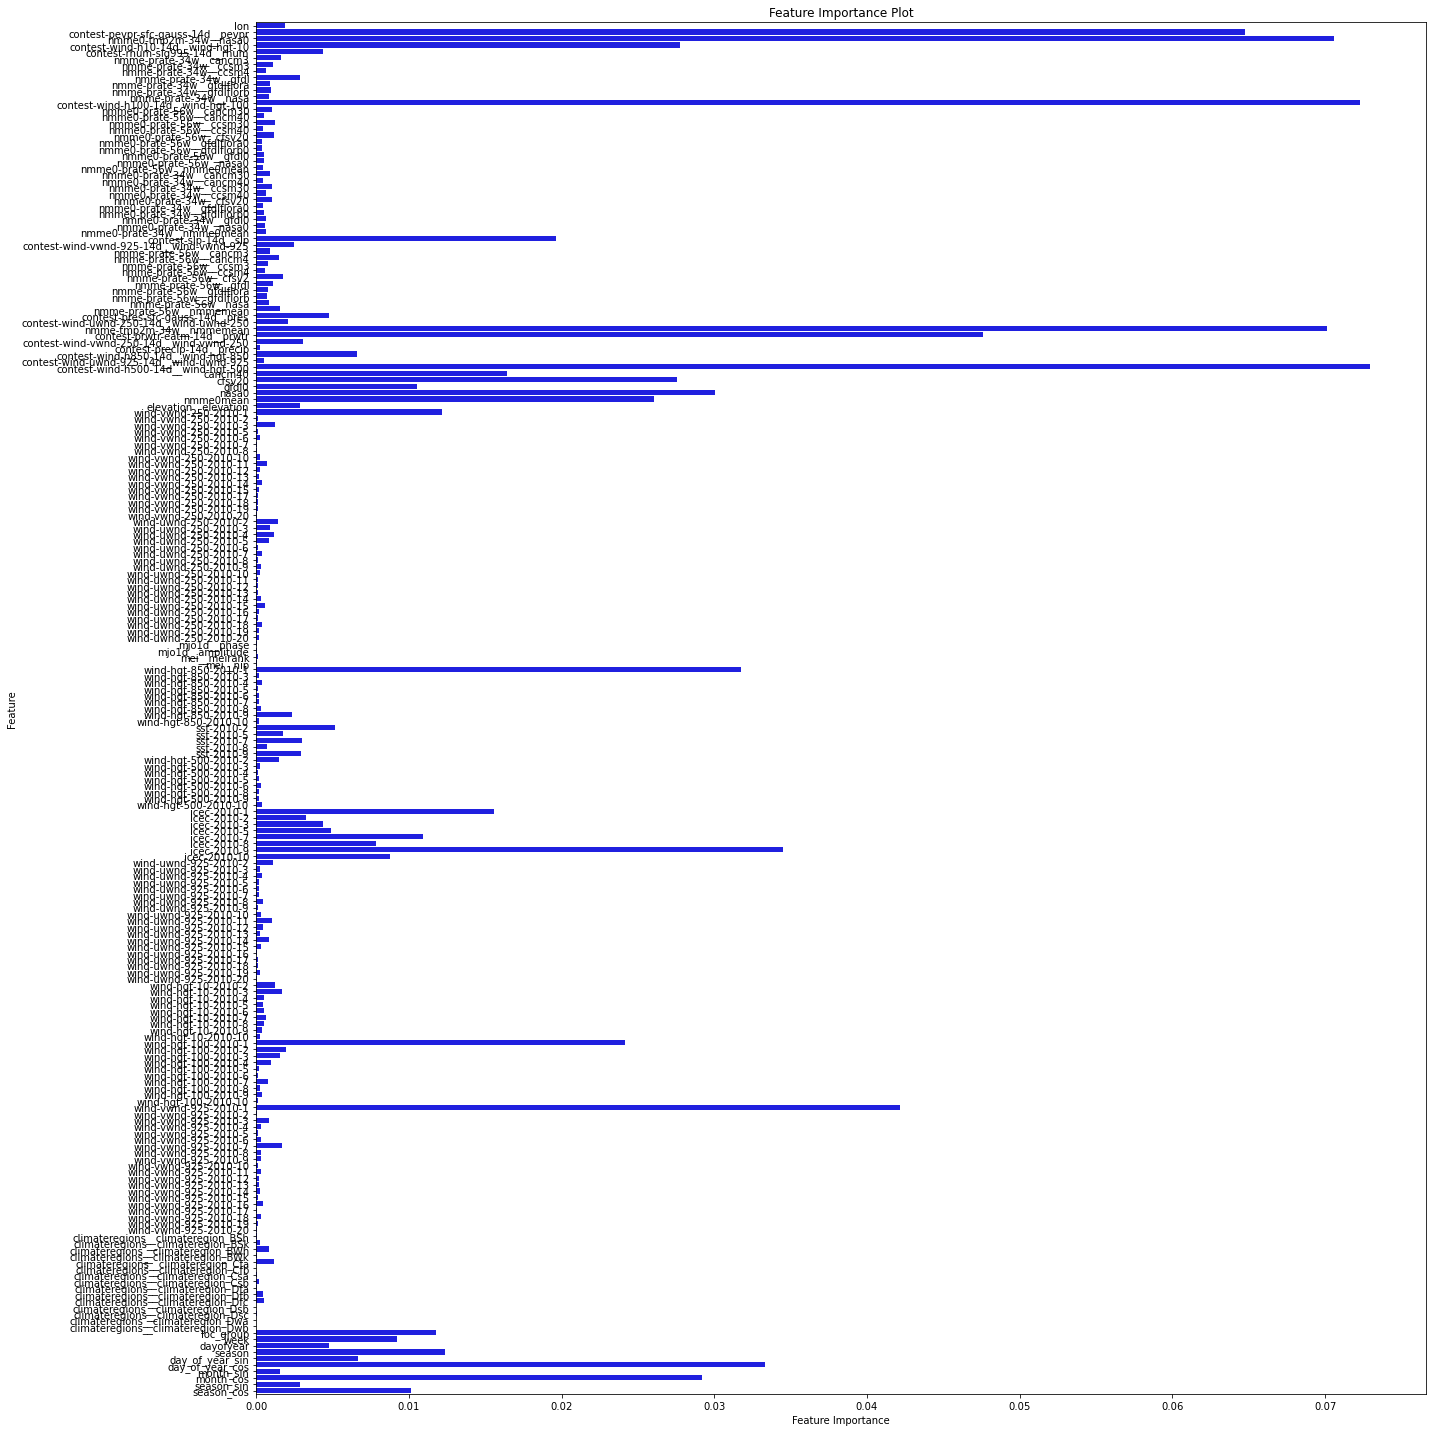

In [52]:
plt.figure(figsize=(20,20))
sns.barplot(x=importances, y=X_train.columns, color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.tight_layout()

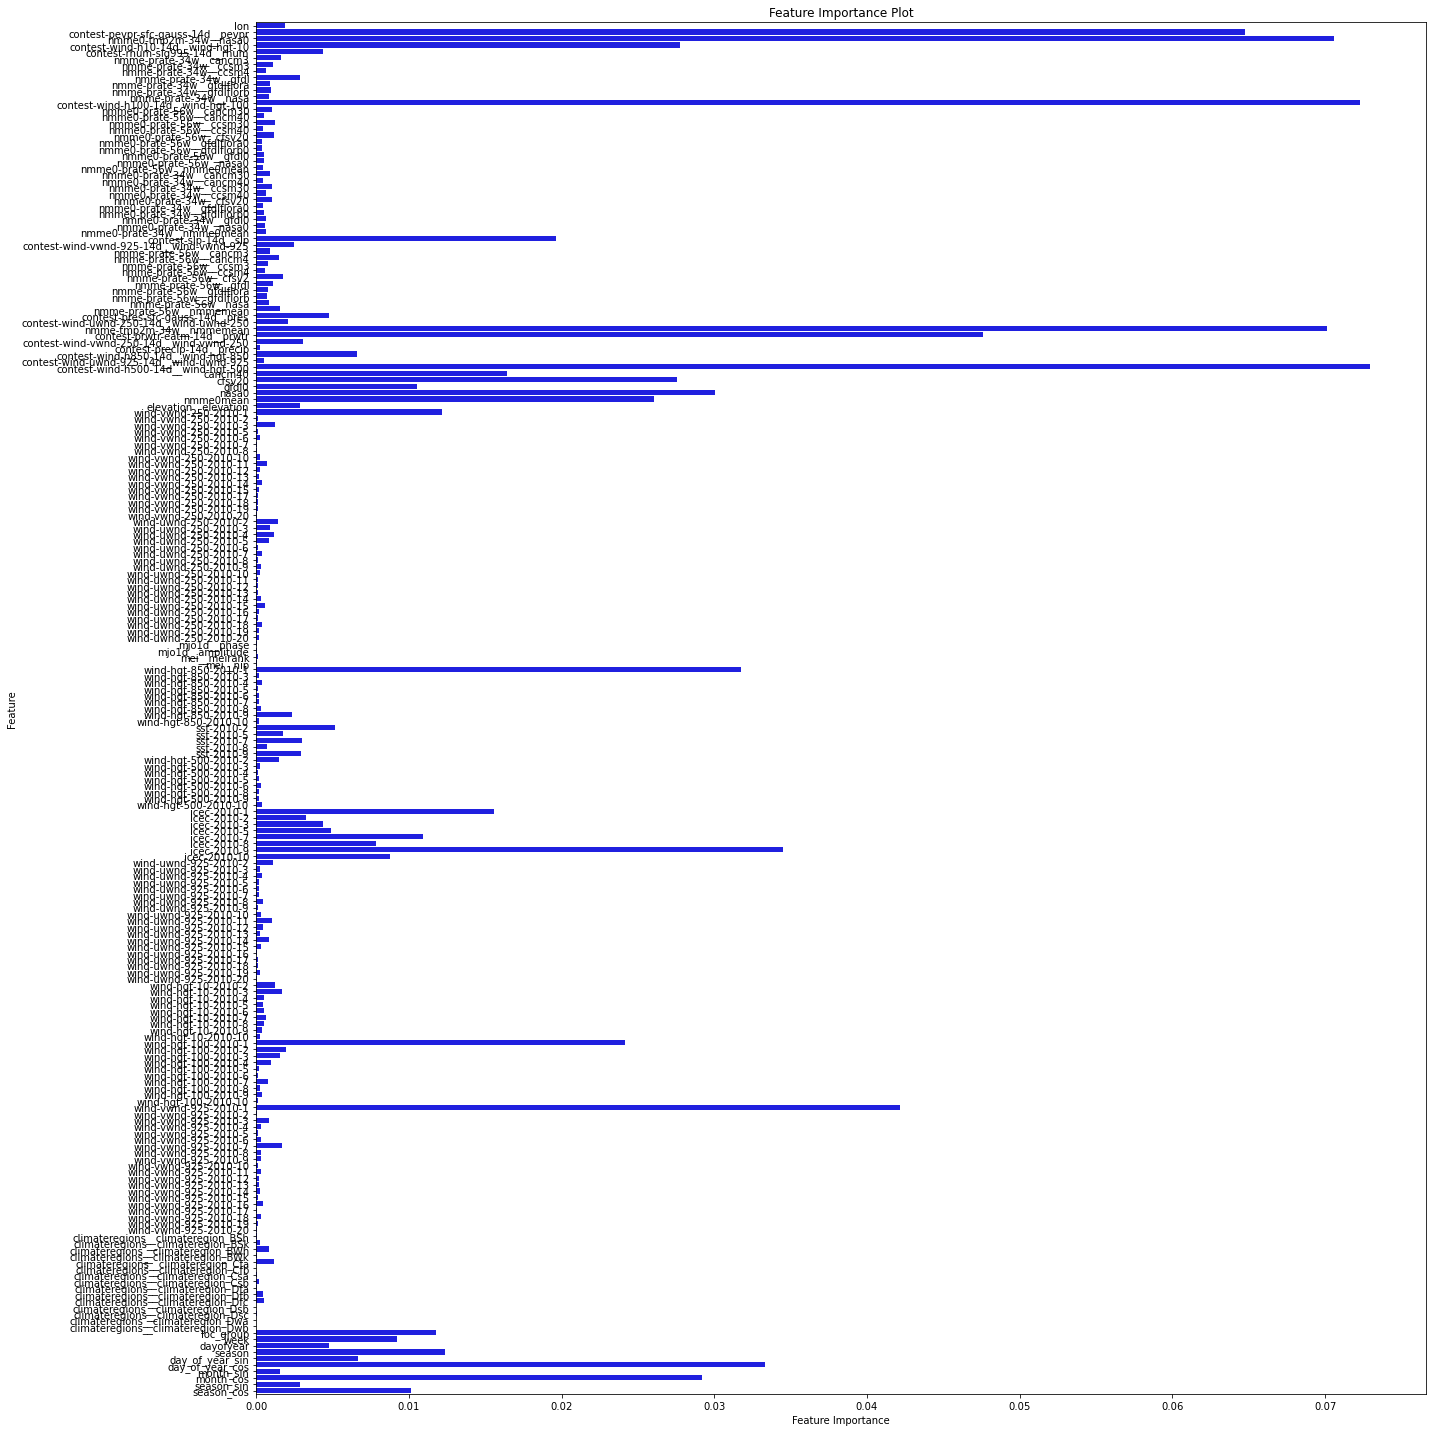

In [53]:
plt.figure(figsize=(20,20))
sns.barplot(x=importances, y=X_test.columns, color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.tight_layout()

In [54]:
# Set the threshold value
threshold = 0.01

# Get the indices of the features with importance values greater than the threshold
important_feature_indices = np.where(importances > threshold)[0]


In [55]:
# Filter the features based on the threshold
X_train_filtered = X_train.iloc[:, important_feature_indices]
X_test_filtered = X_test.iloc[:, important_feature_indices]

In [56]:
print(len(X_train_filtered.columns))

25


In [57]:
print(len(X_test_filtered.columns))

25


In [58]:
pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'))
           ])

rf_model2 = pipeline.fit(X_train_filtered, y_train)

train_preds = rf_model2.predict(X_train_filtered)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
print (f'Training RMSE: {train_rmse}')
train_score = r2_score(y_train, train_preds)
print (f'Training R2: {train_score}')


test_preds = rf_model2.predict(X_test_filtered)
test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
print (f'Test RMSE: {test_rmse}')
test_score = r2_score(y_test, test_preds)
print (f'Test R2: {test_score}')

Training RMSE: 1.4170741974839267
Training R2: 0.979377714744452
Test RMSE: 1.2063176513297003
Test R2: 0.9281244388658064


In [59]:
len(y_test)

31354

In [60]:
y_test.head()

0    27.173184
1    27.155944
2    27.104646
3    27.101517
4    27.067249
Name: contest-tmp2m-14d__tmp2m, dtype: float64

In [61]:
# loading the sample submission file
submission = pd.read_csv('sample_solution.csv')
submission.head()


contest-tmp2m-14d__tmp2m   index
0                 27.073876  375734
1                 25.109308  375735
2                 22.557390  375736
3                 25.572875  375737
4                 20.781073  375738

In [62]:
# #making predictions and replacing the values of the sample file
target_variable = 'contest-tmp2m-14d__tmp2m'
submission[target_variable] = test_preds

submission.tail(20)

contest-tmp2m-14d__tmp2m   index
31334                  9.786692  407068
31335                  9.819042  407069
31336                  9.850298  407070
31337                  9.756395  407071
31338                  9.810819  407072
31339                  9.414717  407073
31340                  9.313873  407074
31341                  9.522382  407075
31342                  9.454594  407076
31343                  9.436713  407077
31344                  9.452454  407078
31345                  7.901259  407079
31346                  7.740908  407080
31347                  7.452137  407081
31348                  6.791867  407082
31349                  6.652567  407083
31350                  6.333766  407084
31351                  5.927712  407085
31352                  5.781667  407086
31353                  5.426588  407087

In [63]:
#save the submission file
submission.to_csv('submission.csv', index = False) 